# Standard Preamble

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.io as sio
import scipy.optimize as opt
import os
import glob
from scipy.stats import norm
import math
from scipy.stats import expon
# import arviz as az
# import pymc3 as pm
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 16})
import warnings
warnings.filterwarnings("ignore")

# Define functions

In [2]:
def UniqueVals(stims, responses):
    
    """
    Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [3]:
def nloglik(params,X,N,K):
    '''
    This function returns the negative log likelihood of the parameters mu and sigma 
    for a data set 
    X = stimuli (vector)
    N = number of trials at each X 
    K = Number of trials with the response of interest
    '''   
    alpha=params[0]
    beta=params[1]
    
    psi = norm.cdf(X,alpha,beta)       
    ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))

    nll = -ll
    
    return nll

In [4]:
def psiBIC(params, data):
    """
    Definition: calculates the bayesian information criteria (BIC) for a psychometric function 
    
    inputs:
    params = vector of the parameters for the psychometric function (alpha, beta), in this case, it only takes two arguments
    data = a list of size 3 containing 
        1) N = the number of trials at each stimulus location
        2) K = the number of 'left' responses at each stimulus location
        3) x = the stimulus locations
    
    outputs:
    BIC
    """   
    #Organize the data
    alpha = params[0]
    beta = params[1]
    N = data[0]
    K = data[1]
    x = data[2]
    
    #Calcualte the log likelihood    
    psi = norm.cdf(x,alpha,beta)
    ll = np.nansum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
    
    #Calculate BIC
    BIC = -2 * ll + np.log(len(N)) * len(params)
    
    return BIC

In [5]:
def psiAIC(params, data):
    """
    Definition: calculates the Akaike information criteria (AIC) for a psychometric function 
    
    inputs:
    params = vector of the parameters for the psychometric function (alpha, beta), in this case, it only takes two arguments
    data = a list of size 3 containing 
        1) N = the number of trials at each stimulus location
        2) K = the number of 'left' responses at each stimulus location
        3) x = the stimulus locations
    
    outputs:
    AIC
    """   
    
    #Organize the data
    alpha = params[0]
    beta = params[1]
    N = data[0]
    K = data[1]
    x = data[2]
    
    #Calcualte the log likelihood    
    psi = norm.cdf(x,alpha,beta)
    ll = np.nansum(K * np.log(psi) + ((N - K) * np.log(1-psi)))

    #Calculate AIC
    AIC = 2*len(params) - 2*ll
    
    return AIC

In [46]:
def Fit_psi(stims, responses, Num_Inits):
    """
    Definition: Uses MLE to fit a psychometric function (normcdf) to data
    
    inputs:
    stims = vector of all stimulus values 
    responses = vector of all responses
    Num_Inits = number of initializations
    
    outputs:
    best_params = best paramers (size 2 vector)
    best_ll = log likelihood of the best parameters
    """   
    
    #Calculate unique values of the stims
    unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

    temp_ll = []
    temp_params = np.empty((Num_Inits,2))
    for i in range(Num_Inits):
        # x0 = [np.random.randint(-30, 30), np.random.randint(0, 30)]
        x0 = [norm.rvs(0,20), expon.rvs(0,20)]
        
        res = opt.minimize(nloglik, x0=x0, args=(unique_stims,Nstims,Kleft),
                method='Nelder-Mead', bounds=((-50,50),(0,50)), options={'disp': False})
        
        temp_ll = np.append(temp_ll, res.fun)
        temp_params[i,:] = res.x

    min_idx = np.nanargmin(temp_ll)
    best_params = temp_params[min_idx]
    best_ll = temp_ll[min_idx]
    
    return best_params, best_ll

In [67]:
def fit_each_trial(stims,responses):
    
    alpha_ev, beta_ev = [], []
    #Loop through each trial
    for i in range(len(stims)):

        current_stim_idx = stims[:i+1]
        current_resp_idx = responses[:i+1]
        
        best_params, best_ll = Fit_psi(current_stim_idx, current_resp_idx, 30)
        
        alpha_ev = np.append(alpha_ev, best_params[0])
        beta_ev = np.append(beta_ev, best_params[1])
        
    return alpha_ev, beta_ev

# Load the data

In [8]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')

#Load the data and combine
file_names = glob.glob("*.csv")
combined_data = [pd.read_csv(i, parse_dates=['StartTime']) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for easy indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

# Confirmatory Analysis

## Are start positions close to equal?

In [9]:
for name, test in grp_tests:
    
    #Calculate the percept of start positions that started above
    started_above = sum(test.AllStarts > test.AllStims)
    above_prct = round((started_above/len(test))*100,1)

    #Print the results
    print(name[0]+name[1])
    print(str(above_prct) + '% of trials started above the stimulus position')

PSItest_21a
52.0% of trials started above the stimulus position
PSItest_21b
44.0% of trials started above the stimulus position
PSItest_22a
53.3% of trials started above the stimulus position
PSItest_22b
49.3% of trials started above the stimulus position
PSItest_23a
44.0% of trials started above the stimulus position
PSItest_23b
46.7% of trials started above the stimulus position
PSItest_24a
60.0% of trials started above the stimulus position
PSItest_24b
52.0% of trials started above the stimulus position
PSItest_25a
46.7% of trials started above the stimulus position
PSItest_25b
49.3% of trials started above the stimulus position
PSItest_26a
54.7% of trials started above the stimulus position
PSItest_26b
44.0% of trials started above the stimulus position
PSItest_27a
42.7% of trials started above the stimulus position
PSItest_27b
49.3% of trials started above the stimulus position
PSItest_28a
50.7% of trials started above the stimulus position
PSItest_28b
50.7% of trials started abov

## Are the start and end speeds randomized?

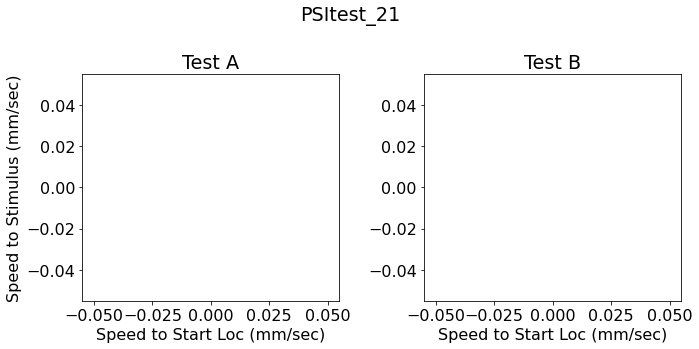

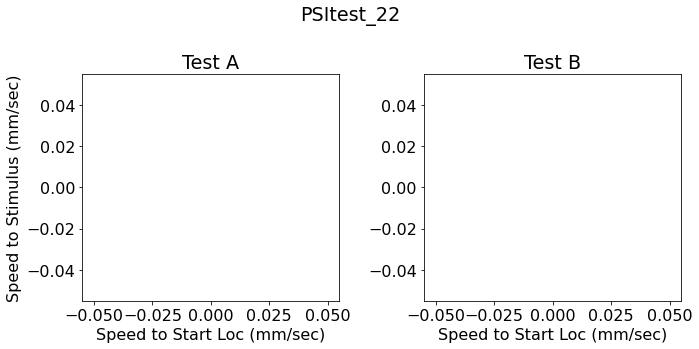

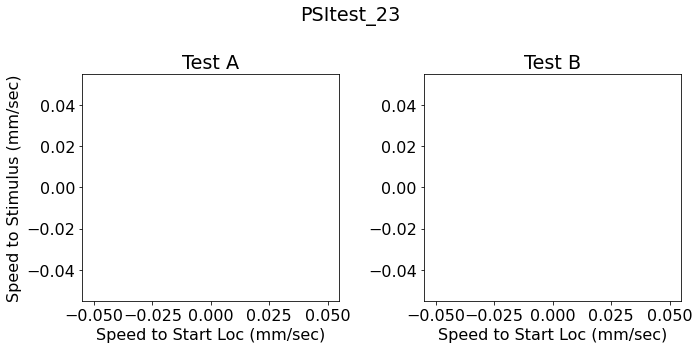

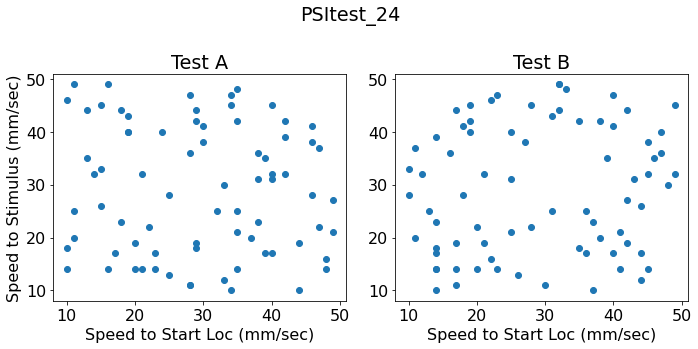

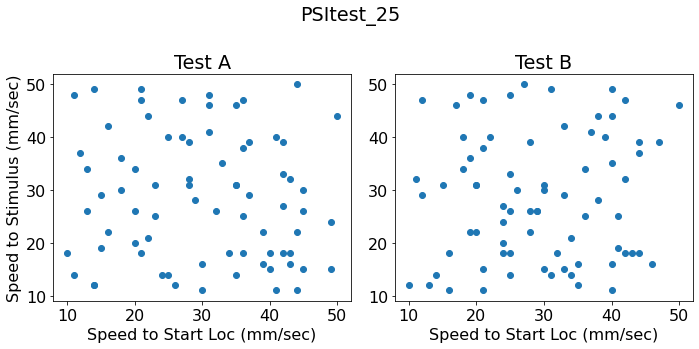

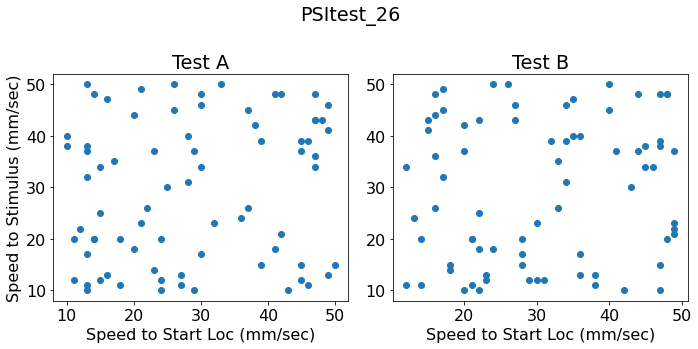

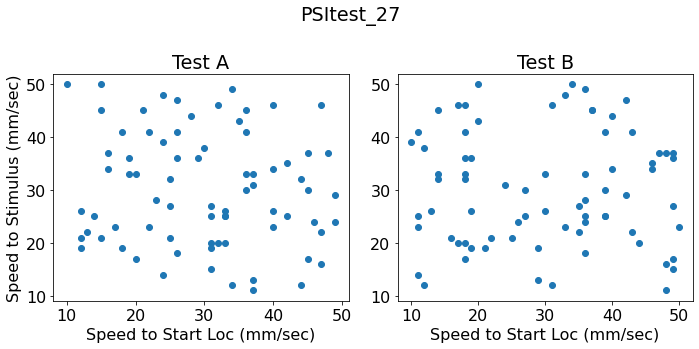

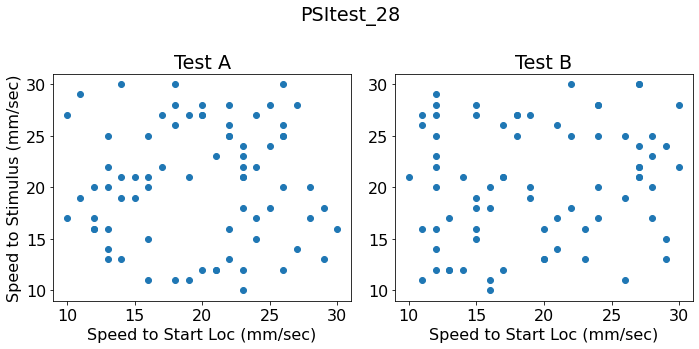

In [10]:
#Loop through all subejcts
for name, test in grp_subjs:
    
    #Index the different tests
    Test_a = test[test.Test=='a']
    Test_b = test[test.Test=='b']
    
    #Plot
    fig, ax = plt.subplots(1,2, figsize=(10,5),tight_layout=True)
    ax[0].plot(Test_a.StartSpeeds, Test_b.StimSpeeds,'o')
    ax[0].set(ylabel='Speed to Stimulus (mm/sec)', xlabel='Speed to Start Loc (mm/sec)', title='Test A')
    ax[1].plot(Test_b.StartSpeeds, Test_b.StimSpeeds,'o')
    ax[1].set(xlabel='Speed to Start Loc (mm/sec)', title='Test B')    
    fig.suptitle(name) 
    plt.show()    

## How much time between the tests, and how long is each test? 

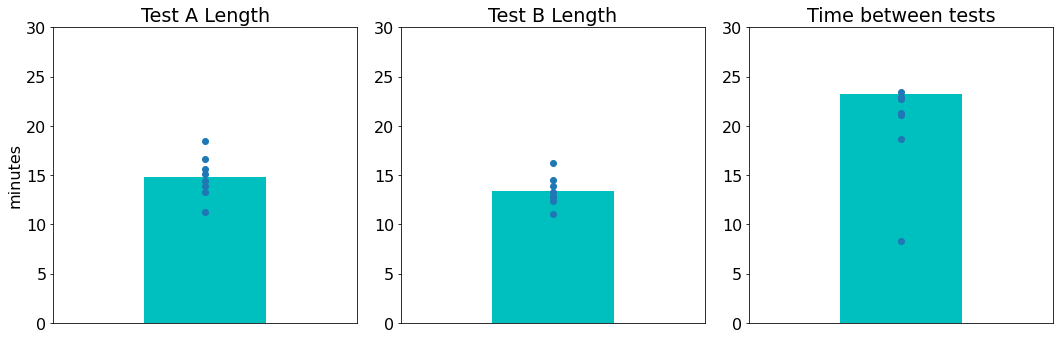

In [11]:
#Loop through all subejcts
all_td, a_len, b_len = [], [], []
for name, test in grp_subjs:
    
    #Index the different tests
    test_a = test[test.Test=='a']
    test_b = test[test.Test=='b']
    
    #calculate the length of each test
    a_len = np.append(a_len, test_a.TestLen[0]/60)
    b_len = np.append(b_len, test_b.TestLen[0]/60)

    #Calculate difference between tests and save
    test_a_end = test_a.StartTime[0] + timedelta(seconds=test_a.TestLen[0])
    time_diff = test_b.StartTime[0] - test_a_end
    all_td = np.append(all_td, time_diff.seconds/60)

#Plot
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
ax[0].bar(0,np.mean(a_len),color='c')
ax[0].plot(np.zeros_like(a_len),a_len,'o')
ax[0].set(xlim=(-1,1), ylim=(0,30), ylabel='minutes', title='Test A Length',xticks=[])

ax[1].bar(0,np.mean(b_len),color='c')
ax[1].plot(np.zeros_like(a_len),b_len,'o')
ax[1].set(xlim=(-1,1), ylim=(0,30), title='Test B Length',xticks=[])

ax[2].bar(0,np.mean(all_td),color='c')
ax[2].plot(np.zeros_like(a_len),all_td,'o')
ax[2].set(xlim=(-1,1), ylim=(0,30), title='Time between tests',xticks=[])
plt.show()

## Are the pre-set simtuli appropriately distributed? DF

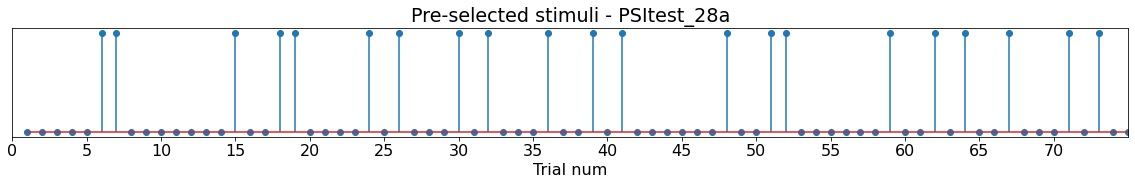

Largest difference between pre-selected stim =  8


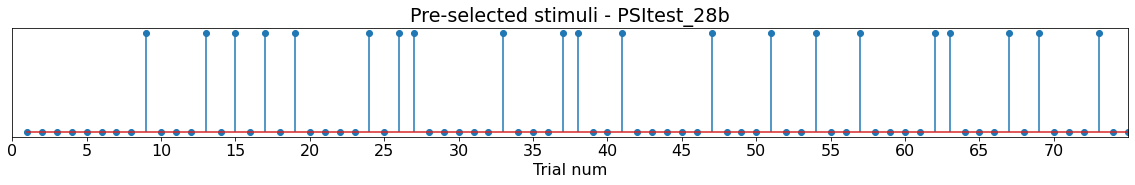

Largest difference between pre-selected stim =  6


In [12]:
for name, test in grp_tests:
    
    if test.SelectedStims.isna()[0]:
        continue
        
    #Plot 
    fig, ax = plt.subplots(figsize=(20,2))
    ax.stem(test.Trial_num,test.SelectedStims)
    ax.set(xlim=(1,75), yticks=[], xticks=np.arange(0,75,5),title='Pre-selected stimuli - '+name[0]+name[1],xlabel='Trial num')
    plt.show()
    
    #Find the max difference between pre-selected stims
    max_diff = np.max(np.diff(test.Trial_num[test.SelectedStims==1]))
    print('Largest difference between pre-selected stim = ', max_diff) 


# Data Analysis 

## Plot the data for each test along with the psi function estimated and fit post-hoc

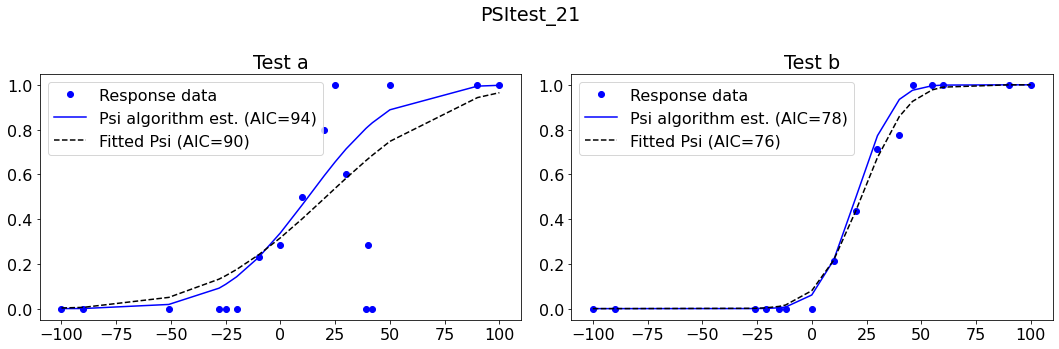

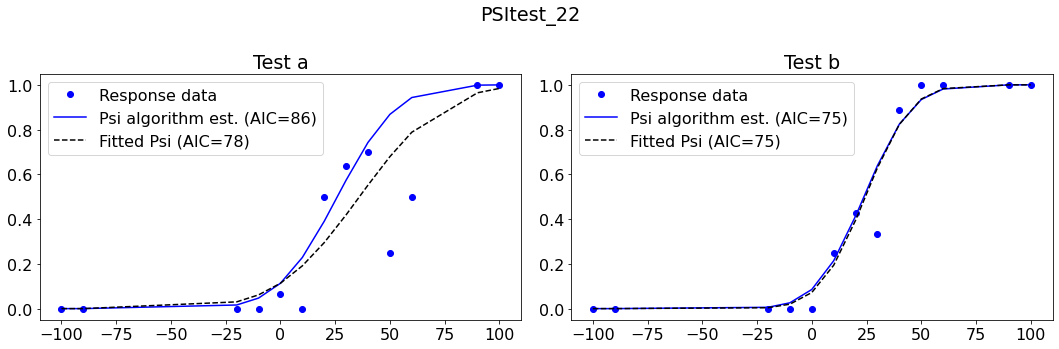

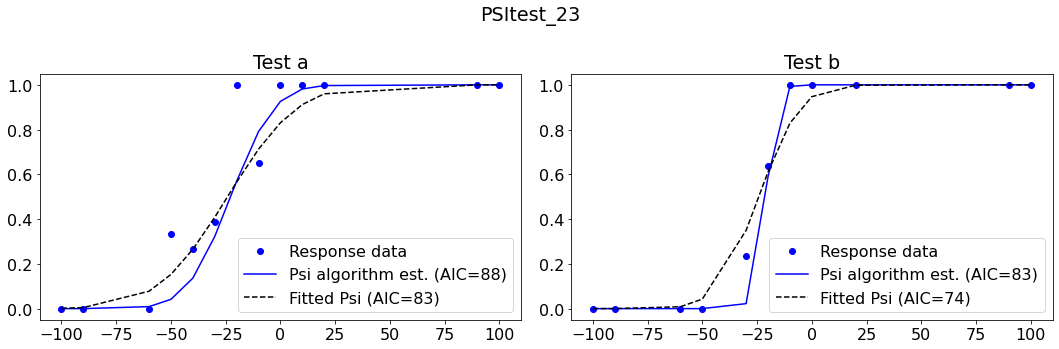

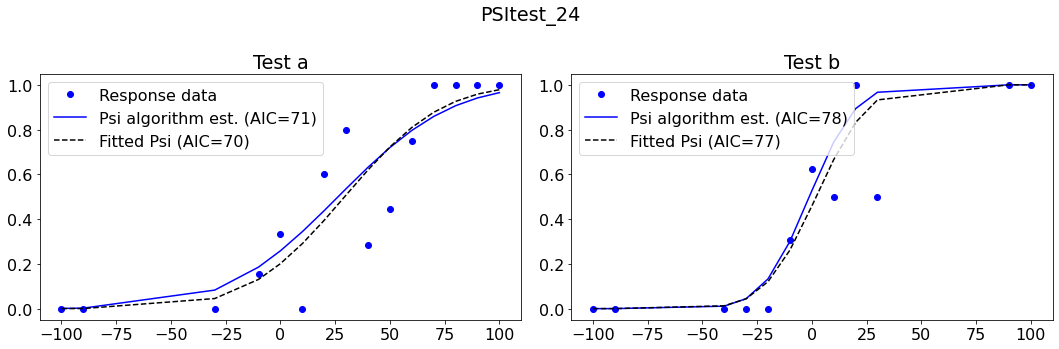

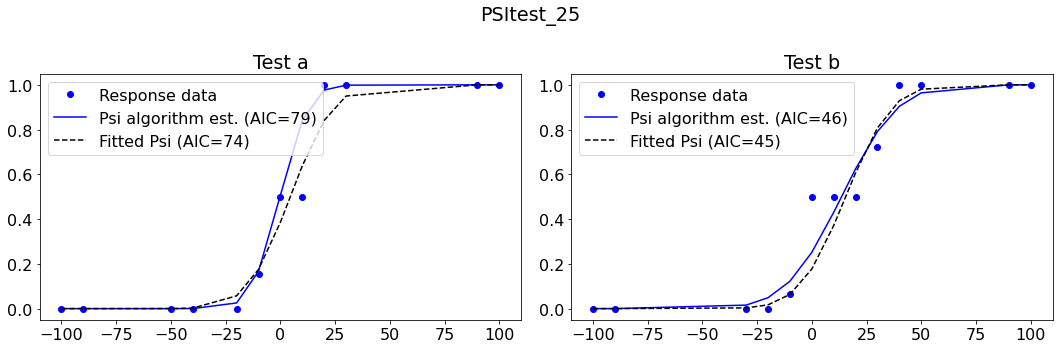

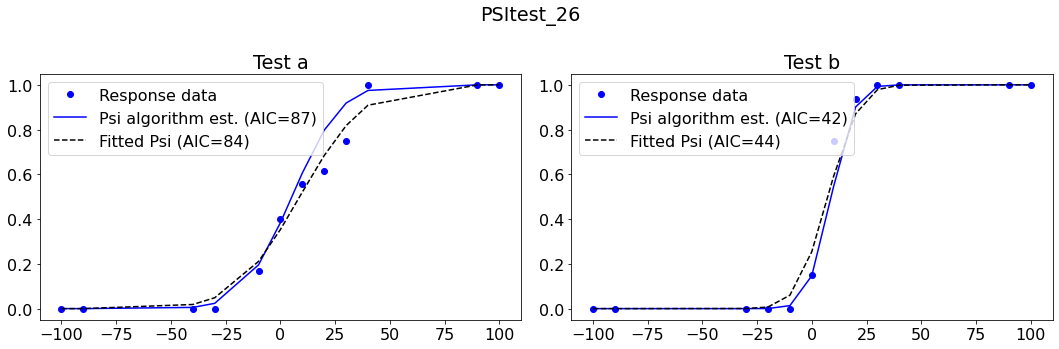

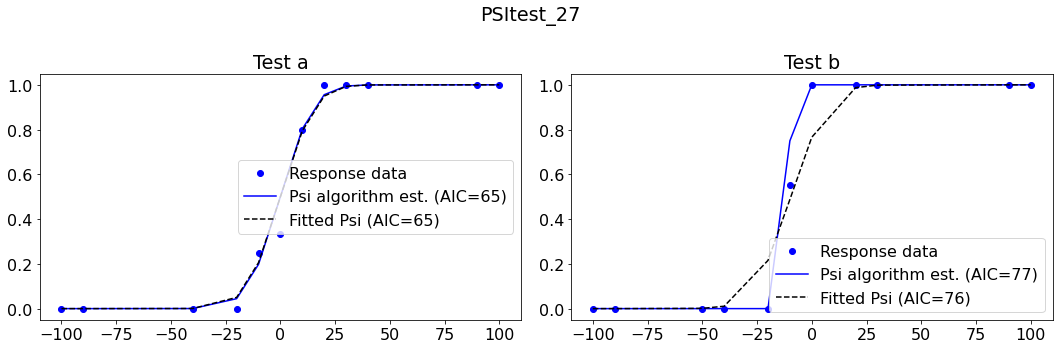

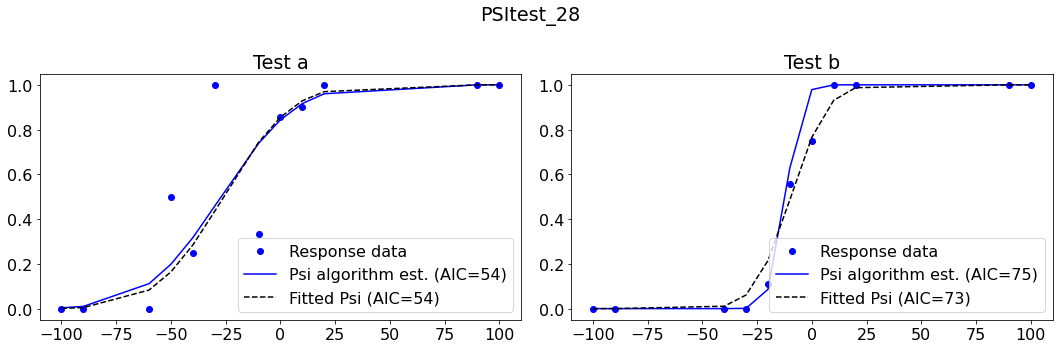

In [51]:
unique_tests = ['a','b']
AIC_diff = []
fit_alphas, fit_betas = np.empty((len(grp_subjs),len(unique_tests))), np.empty((len(grp_subjs),len(unique_tests)))
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    
    fig, ax = plt.subplots(1,2,figsize=(15,5),tight_layout=True)
    for test_id_idx, test_id in enumerate(unique_tests):
        
        #Index the test
        current_test = test[test.Test==test_id]

        #index all the stim positions and baseline correct
        BslDiff = round(current_test.BslDiff.values[0])
        x, Nstims, Kleft = UniqueVals(current_test.AllStims.values+BslDiff, current_test.BinaryResponses.values)

        #Calculate psychometric function for the PSI algorithm
        psi_est = norm.cdf(x,current_test.Alpha_EV.values[-1]+BslDiff,current_test.Beta_EV.values[-1])

        #Use MLE to fit all trials 
        best_params, best_ll = Fit_psi(current_test.AllStims.values+BslDiff, current_test.BinaryResponses.values, 30)

        #Calcualte the function and save the parameters
        psi_fit = norm.cdf(x, best_params[0], best_params[1])
        fit_alphas[subj_name_idx, test_id_idx] = best_params[0]
        fit_betas[subj_name_idx, test_id_idx] = best_params[1]

        #Calculate AIC for both 
        AIC_est = psiAIC([current_test.Alpha_EV.values[-1]+BslDiff,current_test.Beta_EV.values[-1]], [Nstims, Kleft, x])
        AIC_fit = psiAIC(best_params, [Nstims, Kleft, x])
        AIC_diff = np.append(AIC_diff, AIC_fit-AIC_est)

        #Plot
        ax[test_id_idx].plot(x, Kleft/Nstims, 'bo', label='Response data')
        ax[test_id_idx].plot(x, psi_est, 'b', label='Psi algorithm est. (AIC='+  str(round(AIC_est)) +')', alpha=1)
        ax[test_id_idx].plot(x, psi_fit, 'k--', label='Fitted Psi (AIC='+ str(round(AIC_fit)) +')')
        ax[test_id_idx].set(title='Test ' + test_id)
        ax[test_id_idx].legend()
        
    fig.suptitle(name) 
    plt.show()

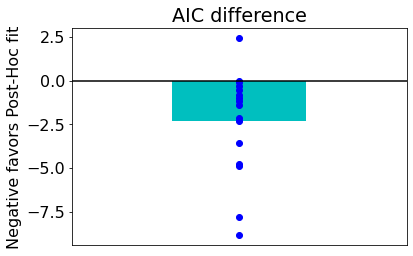

1 tests were fit better by the psi compared to post-hoc
15 tests were fit better by the post-hoc compared to the PSI
0 tests were fit the same


In [52]:
#Plot AIC difference
fig, ax = plt.subplots()
ax.bar(0,np.nanmean(AIC_diff),color='c')
ax.plot(np.zeros_like(AIC_diff),AIC_diff,'bo')
ax.plot(np.arange(-1,2),np.zeros(3),'k')
ax.set(xticks=[], ylabel='Negative favors Post-Hoc fit', xlim=(-1,1), title='AIC difference')
plt.show()
print(np.sum(AIC_diff>0), 'tests were fit better by the psi compared to post-hoc')
print(np.sum(AIC_diff<0), 'tests were fit better by the post-hoc compared to the PSI')
print(np.sum(AIC_diff==0), 'tests were fit the same')

## Plot trial by trial 

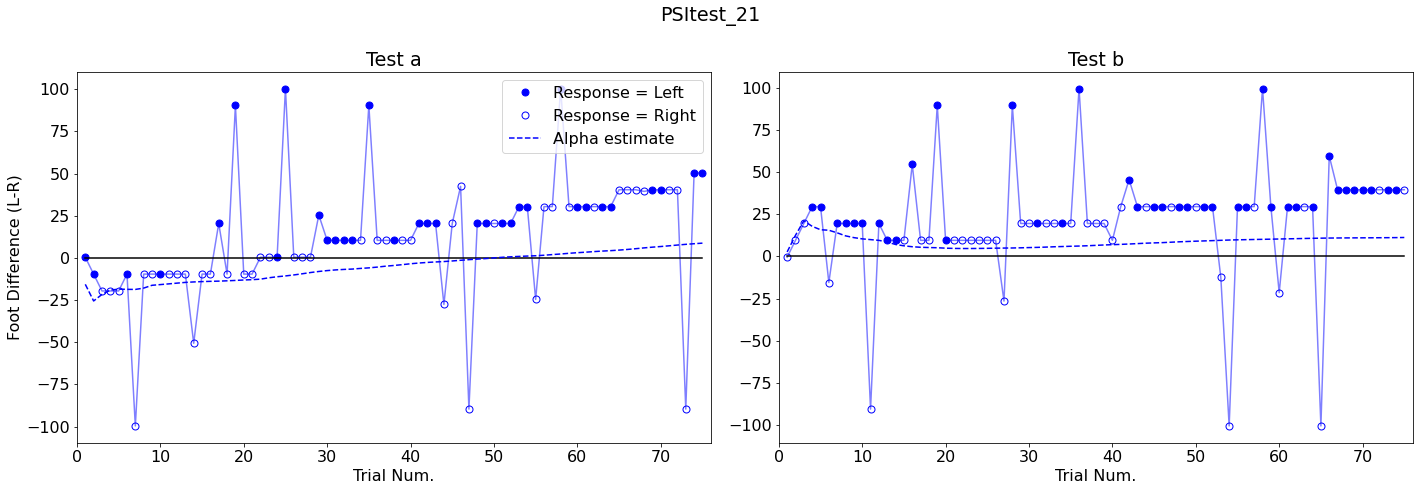

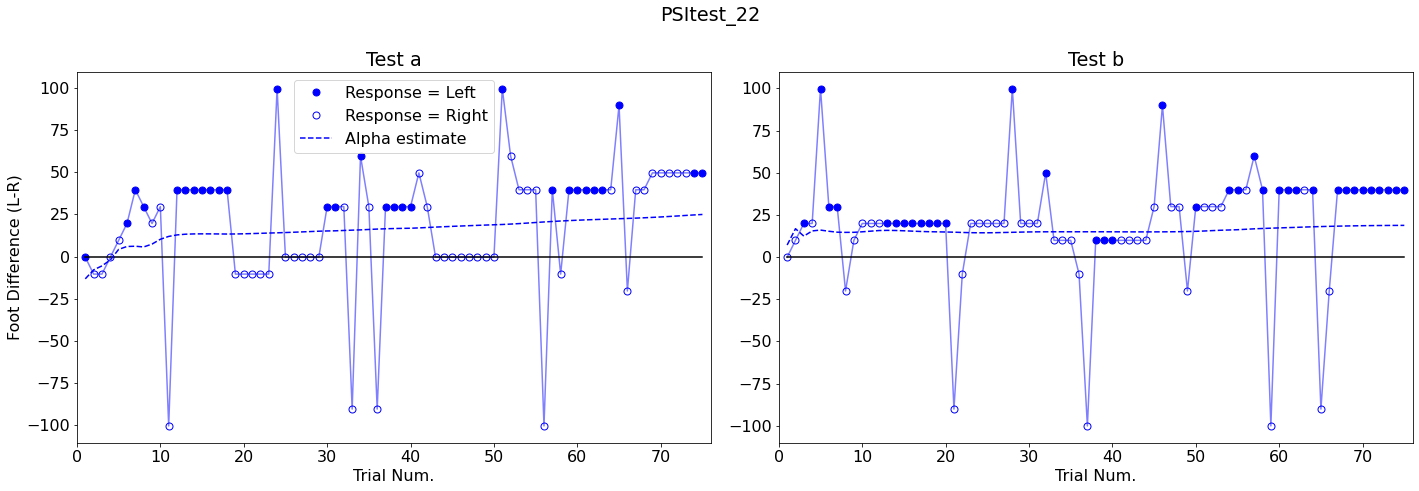

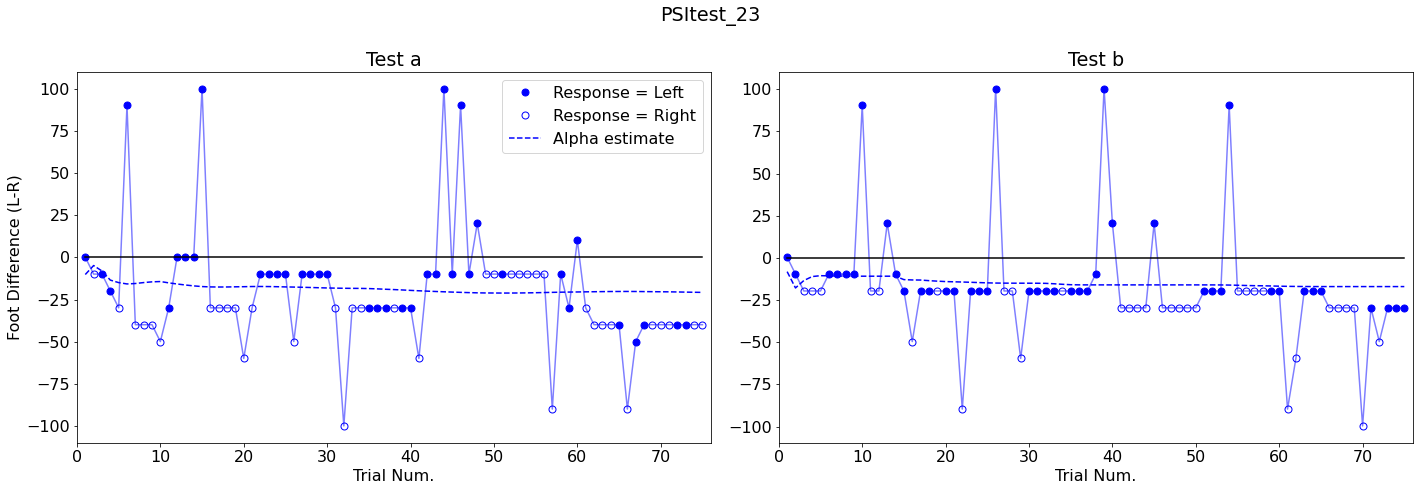

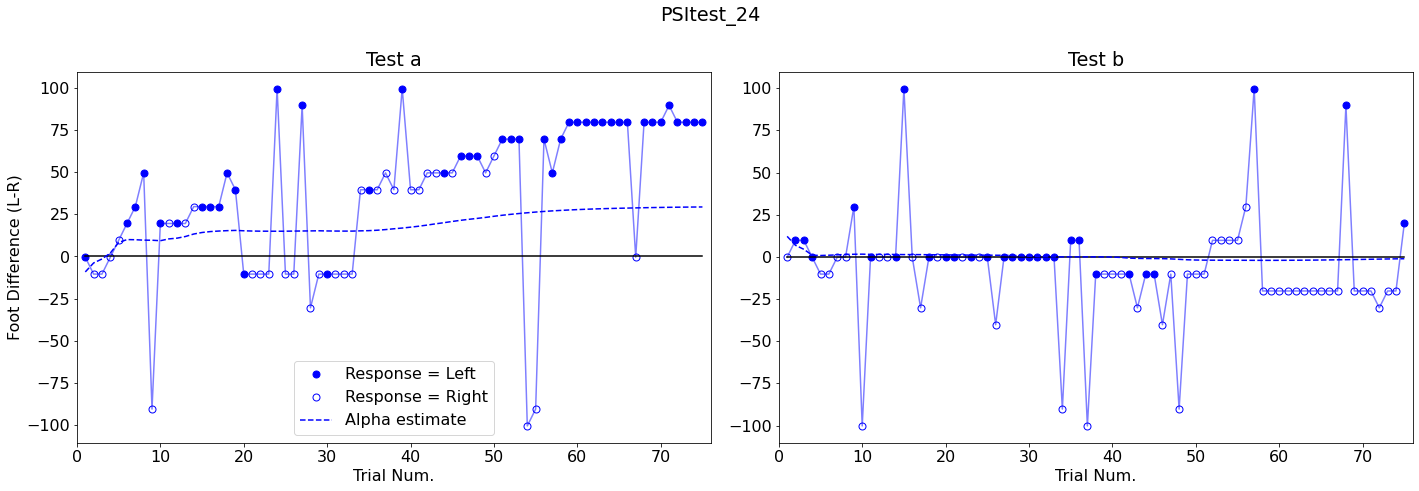

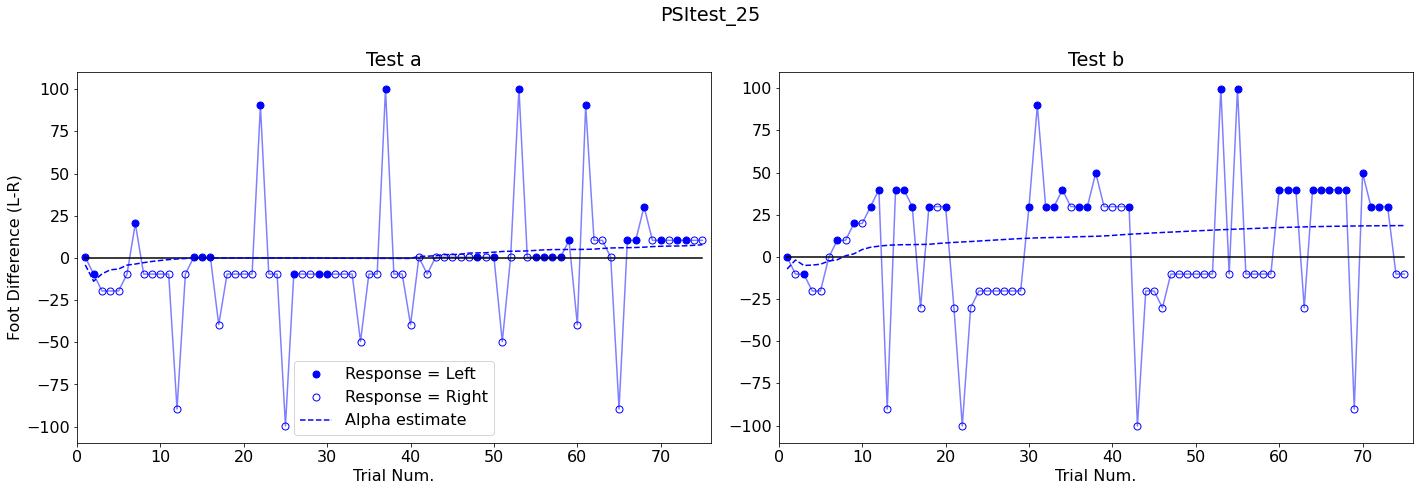

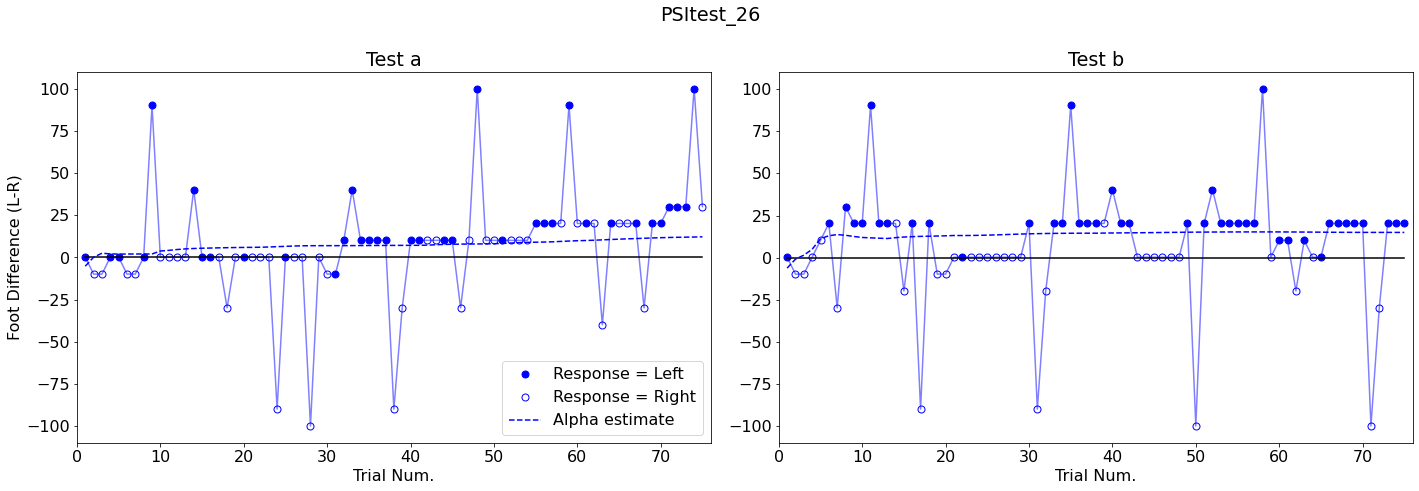

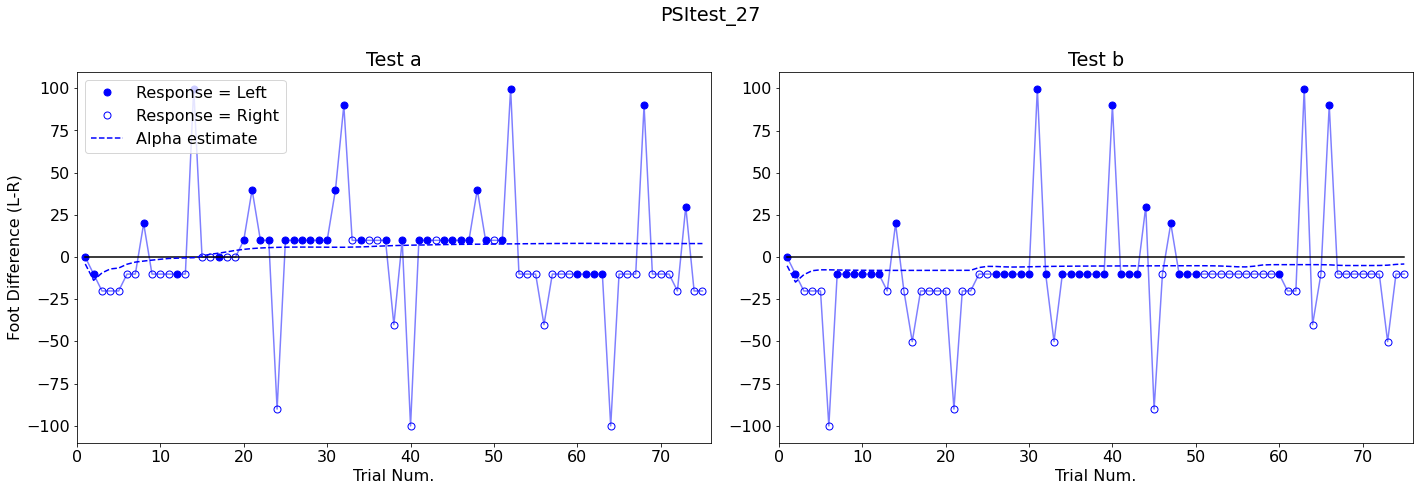

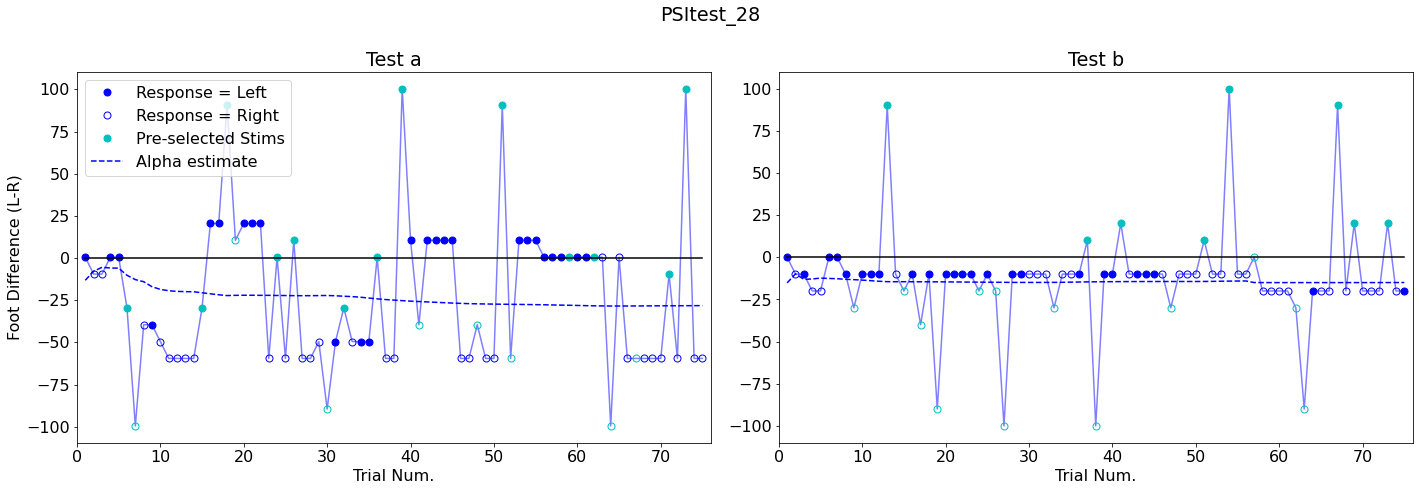

In [64]:
unique_tests = ['a','b']

for name, test in grp_subjs:
    
    fig, ax = plt.subplots(1,2,figsize=(20,7),tight_layout=True)
    for i, test_id_idx in enumerate(unique_tests):
        
        #Index the test
        current_test = test[test.Test==test_id_idx]
        
        #Index stims
        all_stims = current_test.AllStims.values+current_test.BslDiff.values
        
        #Plot
        if current_test.SelectedStims.isna()[0]:
            ax[i].plot(current_test.Trial_num, all_stims,'b',alpha=0.5)
            ax[i].plot(current_test.Trial_num[current_test.BinaryResponses==1], all_stims[current_test.BinaryResponses==1],'bo', markersize=7, label='Response = Left')
            ax[i].plot(current_test.Trial_num[current_test.BinaryResponses==0], all_stims[current_test.BinaryResponses==0],'bo',fillstyle='none', markersize=7, label='Response = Right')
            ax[i].plot(current_test.Trial_num,np.zeros(len(current_test)),'k')
            ax[i].plot(current_test.Trial_num,current_test.Alpha_EV,'b--',label='Alpha estimate')
            ax[i].set(xlabel='Trial Num.', xlim=(0,len(current_test)+1), title='Test ' + test_id_idx)
            ax[0].set(ylabel='Foot Difference (L-R)')
            ax[0].legend()    
            
        else:
            ax[i].plot(current_test.Trial_num, all_stims,'b',alpha=0.5)
            ax[i].plot(current_test.Trial_num[(current_test.SelectedStims==0) & (current_test.BinaryResponses==1)], 
                       all_stims[(current_test.SelectedStims==0) & (current_test.BinaryResponses==1)],'bo', markersize=7, label='Response = Left')
            ax[i].plot(current_test.Trial_num[(current_test.SelectedStims==0) & (current_test.BinaryResponses==0)], 
                       all_stims[(current_test.SelectedStims==0) & (current_test.BinaryResponses==0)],'bo',fillstyle='none', markersize=7, label='Response = Right')

            ax[i].plot(current_test.Trial_num[(current_test.SelectedStims==1) & (current_test.BinaryResponses==1)], 
                       all_stims[(current_test.SelectedStims==1) & (current_test.BinaryResponses==1)],'co', markersize=7, label='Pre-selected Stims')
            ax[i].plot(current_test.Trial_num[(current_test.SelectedStims==1) & (current_test.BinaryResponses==0)], 
                       all_stims[(current_test.SelectedStims==1) & (current_test.BinaryResponses==0)],'co',fillstyle='none', markersize=7)
            ax[i].plot(current_test.Trial_num,np.zeros(len(current_test)),'k')
            ax[i].plot(current_test.Trial_num,current_test.Alpha_EV,'b--',label='Alpha estimate')
            ax[i].set(xlabel='Trial Num.', xlim=(0,len(current_test)+1), title='Test ' + test_id_idx)
            ax[0].set(ylabel='Foot Difference (L-R)')
            ax[0].legend()
                  
    fig.suptitle(name) 
    plt.show()

## Test A vs Test B

### PSI algorithm comparison

N = 8


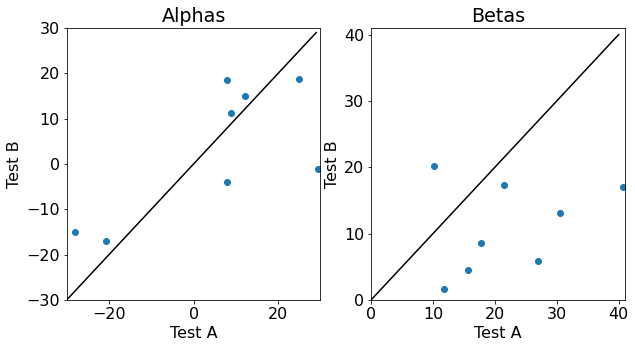

In [43]:
unique_tests = ['a','b']
alphas, betas = np.empty((len(grp_subjs),2)), np.empty((len(grp_subjs),2))

print('N =', len(grp_subjs))
#Extract the final estimates of the alpha and beta values
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        alphas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Alpha_EV.values[-1]
        betas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Beta_EV.values[-1]
        
#Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(alphas[:,0], alphas[:,1],'o')
ax[0].plot(np.arange(-30,30), np.arange(-30,30),'k')
ax[0].set(xlim=(-30,30), ylim=(-30,30), title='Alphas', xlabel='Test A', ylabel='Test B')
ax[1].plot(betas[:,0], betas[:,1],'o')
ax[1].plot(np.arange(0,41), np.arange(0,41),'k')
ax[1].set(xlim=(0,41), ylim=(0,41), title='Betas', xlabel='Test A', ylabel='Test B')
plt.show()

### Post-hoc fit comparison

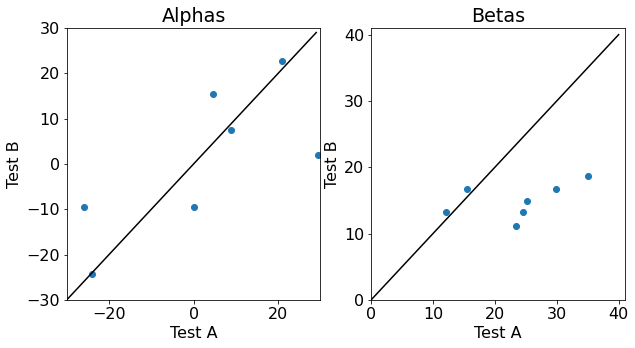

In [44]:
#Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(fit_alphas[:,0], fit_alphas[:,1],'o')
ax[0].plot(np.arange(-30,30), np.arange(-30,30),'k')
ax[0].set(xlim=(-30,30), ylim=(-30,30), title='Alphas', xlabel='Test A', ylabel='Test B')
ax[1].plot(fit_betas[:,0], fit_betas[:,1],'o')
ax[1].plot(np.arange(0,41), np.arange(0,41),'k')
ax[1].set(xlim=(0,41), ylim=(0,41), title='Betas', xlabel='Test A', ylabel='Test B')
plt.show()

## Plot both the PSI parameter estiamtes along with the MLE ones

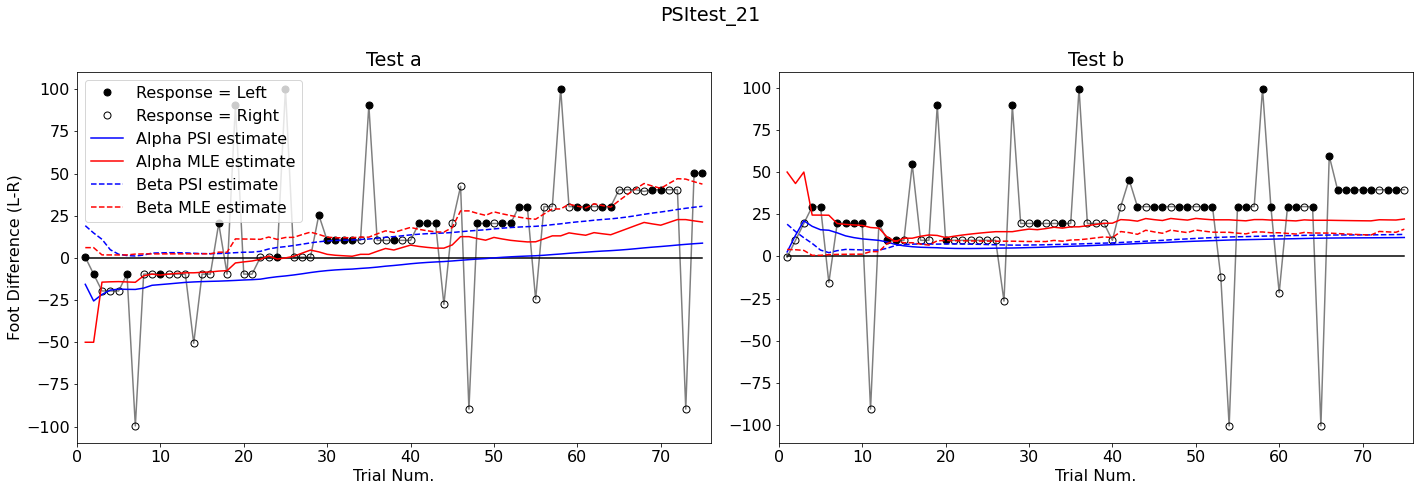

KeyboardInterrupt: 

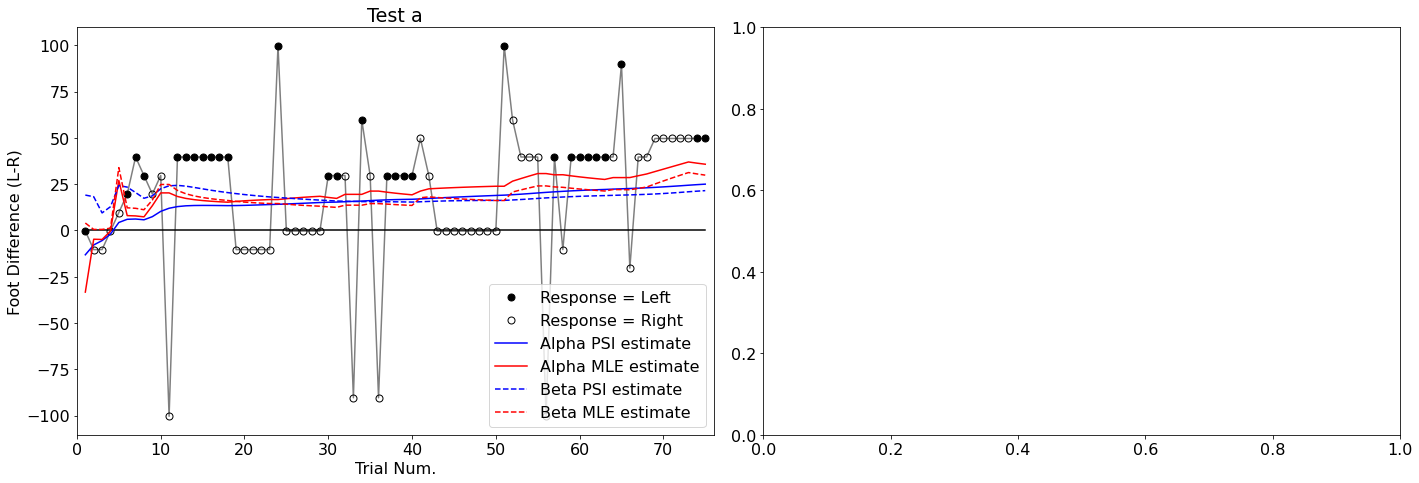

In [70]:
unique_tests = ['a','b']

for name, test in grp_subjs:
    
    fig, ax = plt.subplots(1,2,figsize=(20,7),tight_layout=True)
    for i, test_id_idx in enumerate(unique_tests):
        
        #Index the test
        current_test = test[test.Test==test_id_idx]
        
        #Index stims
        all_stims = current_test.AllStims.values+current_test.BslDiff.values
        
        #Get trial by trial fits to see where it deviates 
        alpha_MLE, beta_MLE = fit_each_trial(all_stims,current_test.BinaryResponses.values)
        
        #Plot
        ax[i].plot(current_test.Trial_num, all_stims,'k',alpha=0.5)
        ax[i].plot(current_test.Trial_num[current_test.BinaryResponses==1], all_stims[current_test.BinaryResponses==1],'ko', markersize=7, label='Response = Left')
        ax[i].plot(current_test.Trial_num[current_test.BinaryResponses==0], all_stims[current_test.BinaryResponses==0],'ko',fillstyle='none', markersize=7, label='Response = Right')
        ax[i].plot(current_test.Trial_num,np.zeros(len(current_test)),'k')
        ax[i].plot(current_test.Trial_num,current_test.Alpha_EV,'b-',label='Alpha PSI estimate')
        ax[i].plot(current_test.Trial_num,alpha_MLE,'r-',label='Alpha MLE estimate')
        ax[i].plot(current_test.Trial_num,current_test.Beta_EV,'b--',label='Beta PSI estimate')
        ax[i].plot(current_test.Trial_num,beta_MLE,'r--',label='Beta MLE estimate')        
        ax[i].set(xlabel='Trial Num.', xlim=(0,len(current_test)+1), title='Test ' + test_id_idx)
        ax[0].set(ylabel='Foot Difference (L-R)')
        ax[0].legend()    
                  
    fig.suptitle(name) 
    plt.show()

# Simulations

## Simulate each individuals parameters and compare the simulations to the data

## Simulate the stimulus selections